# Data Handling

Connect with Google Drive

In [1]:
from google.colab import drive
drive.mount('content')

Mounted at content


Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Defining features names

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
dftrain = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001_1_70.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001_71_100.txt',sep='\s+',header=None,index_col=False,names=col_names)
dffull_data = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
# y_valid : A vector of true Remaining Useful Life (RUL) values for the test data.
# y_valid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
# dfvalid.shape

In [5]:
train = dftrain.copy() # Engine 1~70 (dataset 1)
valid = dfvalid.copy() # Engine 71~100 (dataset 1)
full_data = dffull_data.copy() # Engine 1~100 (dataset 1)

Add RUL column to the data

RUL corresponds to the remaining time cycles for each unit before it falls.

In [6]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [7]:
train = add_RUL_column(train)
valid = add_RUL_column(valid)
full_data = add_RUL_column(full_data)

In [8]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

Plotting the evolution of features (sensors) along with the evolution with RUL

MinMax scaler function : Transform features by scaling each feature to a given range.

This estimater scales and translates each feature individually such that it is in the given range on the training set

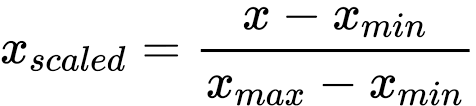

Dropping unnecessary features (labels and settings)

In [9]:
# 임시 코드
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names

# index_name을 split해서 보관해뒀다가 추후에 병합해줘야 RL에 적용할 수 있음
X_train_index_names = train[['unit_number', 'time_cycles']]
X_train = train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test = train_test_split(X_train, X_train['RUL'], test_size = 0.01, random_state = 42, shuffle = False)

# Valid 코드도 수정해야 LR 가능함. ################################
# Valid data : engine 71~100
X_valid_index_names = valid[['unit_number','time_cycles']]
y_valid = valid[['RUL']]
X_valid = valid.drop(columns=drop_labels).copy()

X_full_index_names = full_data[['unit_number','time_cycles']]
y_full = full_data[['RUL']]
X_full = full_data.drop(columns=drop_labels).copy()

Test Code

In [10]:
print(y_train)
print(X_train)

0        191
1        190
2        189
3        188
4        187
        ... 
13983      9
13984      8
13985      7
13986      6
13987      5
Name: RUL, Length: 13988, dtype: int64
          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
13983  518.67  643.73  1598.88  1425.36  14.62  21.61  551.97  2388.25   
13984  518.67  643.66  1606.28  1430.15  14.62  21.61  550.34  2388.25   
13985  518.67  643.34  1593.05  1425.27  14.62  21.61  551.62  2388.24   
13986  518.67  643.19  1605.11  1428.43  14.62  21.61  551.02  2388.25   
1398

In [11]:
print(y_valid)
print(X_valid)

      RUL
0     207
1     206
2     205
3     204
4     203
...   ...
6496    4
6497    3
6498    2
6499    1
6500    0

[6501 rows x 1 columns]
         s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0     518.67  642.64  1581.95  1407.04  14.62  21.61  553.56  2388.11   
1     518.67  642.82  1593.17  1403.53  14.62  21.61  553.22  2388.11   
2     518.67  642.50  1582.94  1402.54  14.62  21.61  553.70  2388.11   
3     518.67  643.04  1584.90  1409.75  14.62  21.61  554.30  2388.14   
4     518.67  642.00  1587.63  1400.43  14.62  21.61  553.49  2388.09   
...      ...     ...      ...      ...    ...    ...     ...      ...   
6496  518.67  643.49  1597.98  1428.63  14.62  21.61  551.43  2388.19   
6497  518.67  643.54  1604.50  1433.58  14.62  21.61  550.86  2388.23   
6498  518.67  643.42  1602.46  1428.18  14.62  21.61  550.94  2388.24   
6499  518.67  643.23  1605.26  1426.53  14.62  21.61  550.68  2388.25   
6500  518.67  643.85  1600.38  1432.14  14.62  21.61

Scaling the data

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  # MinMaxScaler

#Droping the target variable (True RUL)
X_train.drop(columns=['RUL'], inplace=True) # inplace -> true면 원본 삭제 (current option)  # inplace -> False면 원본은 유지

#Scaling X_train
X_train_s=scaler.fit_transform(X_train)

#Conserve only the last occurence of each unit to match the length of y_valid
#X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

X_valid.drop(columns=['RUL'], inplace=True)
X_valid_s = scaler.transform(X_valid)

X_full.drop(columns=['RUL'], inplace=True)
X_full_s = scaler.transform(X_full)
#scaling X_valid
#X_valid_s=scaler.fit_transform(X_valid)

#fit_transform() : for train data ; transform() : for test data

In [13]:
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
13983  518.67  643.73  1598.88  1425.36  14.62  21.61  551.97  2388.25   
13984  518.67  643.66  1606.28  1430.15  14.62  21.61  550.34  2388.25   
13985  518.67  643.34  1593.05  1425.27  14.62  21.61  551.62  2388.24   
13986  518.67  643.19  1605.11  1428.43  14.62  21.61  551.02  2388.25   
13987  518.67  643.86  1601.80  1428.18  14.62  21.61  550.53  2388.25   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0      9046.19   1.3  ...  521

In [14]:
print(X_train_s)

[[0.         0.18373494 0.42515379 ... 0.         0.70866142 0.72548186]
 [0.         0.28313253 0.47345637 ... 0.         0.66141732 0.73200113]
 [0.         0.34337349 0.38619275 ... 0.         0.62204724 0.61947279]
 ...
 [0.         0.64156627 0.50148098 ... 0.         0.26771654 0.07993197]
 [0.         0.59638554 0.77625883 ... 0.         0.21259843 0.24050454]
 [0.         0.79819277 0.70084302 ... 0.         0.31496063 0.3064059 ]]


In [15]:
print(X_valid_s.shape)
print(y_valid.shape)
print(X_valid)
print(X_valid_s)

(6501, 21)
(6501, 1)
         s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0     518.67  642.64  1581.95  1407.04  14.62  21.61  553.56  2388.11   
1     518.67  642.82  1593.17  1403.53  14.62  21.61  553.22  2388.11   
2     518.67  642.50  1582.94  1402.54  14.62  21.61  553.70  2388.11   
3     518.67  643.04  1584.90  1409.75  14.62  21.61  554.30  2388.14   
4     518.67  642.00  1587.63  1400.43  14.62  21.61  553.49  2388.09   
...      ...     ...      ...      ...    ...    ...     ...      ...   
6496  518.67  643.49  1597.98  1428.63  14.62  21.61  551.43  2388.19   
6497  518.67  643.54  1604.50  1433.58  14.62  21.61  550.86  2388.23   
6498  518.67  643.42  1602.46  1428.18  14.62  21.61  550.94  2388.24   
6499  518.67  643.23  1605.26  1426.53  14.62  21.61  550.68  2388.25   
6500  518.67  643.85  1600.38  1432.14  14.62  21.61  550.79  2388.26   

          s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0     9042.70   1.3  .

In [16]:
print(y_valid)

      RUL
0     207
1     206
2     205
3     204
4     203
...   ...
6496    4
6497    3
6498    2
6499    1
6500    0

[6501 rows x 1 columns]


# Model Implementation

Defining evaluation functions

In [17]:
# R2 score & RMSE & MSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat) # R2 score (R-squared) : indep. var.이 depend. var.을 얼마나 잘 설명하는가 (회귀모델 평가지표)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [18]:
# plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6                                # width
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values] # y : RUL
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

**Use all feature**

In [19]:
X_train_1=X_train
X_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1

y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)

X_valid_1=X_valid
X_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1

X_full_1=X_full
X_full_1_s=scaler.fit_transform(X_full_1) #scaling X_full_1


In [20]:
print(X_train_1_s)
print(X_train_1_s.shape)
print(X_valid_1_s)
print(X_valid_1_s.shape)
print(X_full_1_s)
print(X_full_1_s.shape)

[[0.         0.18373494 0.42515379 ... 0.         0.70866142 0.72548186]
 [0.         0.28313253 0.47345637 ... 0.         0.66141732 0.73200113]
 [0.         0.34337349 0.38619275 ... 0.         0.62204724 0.61947279]
 ...
 [0.         0.64156627 0.50148098 ... 0.         0.26771654 0.07993197]
 [0.         0.59638554 0.77625883 ... 0.         0.21259843 0.24050454]
 [0.         0.79819277 0.70084302 ... 0.         0.31496063 0.3064059 ]]
(13988, 21)
[[0.         0.44267516 0.23751363 ... 0.         0.72649573 0.47735432]
 [0.         0.5        0.48222465 ... 0.         0.60683761 0.54473902]
 [0.         0.39808917 0.25910578 ... 0.         0.66666667 0.65258216]
 ...
 [0.         0.6910828  0.68484188 ... 0.         0.25641026 0.05399061]
 [0.         0.63057325 0.74591058 ... 0.         0.12820513 0.23446562]
 [0.         0.82802548 0.63947655 ... 0.         0.1965812  0.21817178]]
(6501, 21)
[[0.         0.18373494 0.40680183 ... 0.         0.71317829 0.7246617 ]
 [0.         0.2

In [21]:
print(y_train_clip)
print(y_train_clip.shape)

0        191
1        190
2        189
3        188
4        187
        ... 
13983      9
13984      8
13985      7
13986      6
13987      5
Name: RUL, Length: 13988, dtype: int64
(13988,)


# **Loss function Tuning**

In [22]:
# 1. Crucial moments loss function - Linear Regression

# Filter and save only data that is less than 20.
filtered_data = X_train_1_s[y_train_clip <= 20]
filtered_labels = y_train_clip[y_train_clip <= 20]

lr1 = LinearRegression()

lr1.fit(filtered_data, filtered_labels) #Fitting

y_lr_train_1 = lr1.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_1, label='train')

y_lr_valid_1 = lr1.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_1, label='valid')

y_lr_full_1 = lr1.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_1, label='full data')

print(lr1.coef_)

train set RMSE:86.8353227672848, R2:-1.1137606035322598
valid set RMSE:106.77987488106757, R2:-1.1341331632692775
full data set RMSE:97.59254812030471, R2:-1.0075002264796886
[ 0.00000000e+00 -5.08462265e+00 -4.18002763e+00 -8.10483333e+00
 -3.55271368e-15 -8.88178420e-15  7.31600597e+00 -9.66684581e+00
 -1.95844999e+01  7.77156117e-16 -1.22962765e+01  8.62807941e+00
 -8.81376053e+00  6.56941918e+00 -7.05811335e+00  0.00000000e+00
 -2.56050425e+00 -4.59177481e-41  1.63132612e-55  6.49639360e+00
  4.70340339e+00]


In [23]:
# 2. Crucial moments loss function - Linear Regression

# Filter and save only data that is less than 50.
filtered_data = X_train_1_s[y_train_clip <= 50]
filtered_labels = y_train_clip[y_train_clip <= 50]

lr2 = LinearRegression()

lr2.fit(filtered_data, filtered_labels) #Fitting

y_lr_train_2 = lr2.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_2, label='train')

y_lr_valid_2 = lr2.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_2, label='valid')

y_lr_full_2 = lr2.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_2, label='full data')

print(lr2.coef_)

train set RMSE:71.57127730270611, R2:-0.4359538729900654
valid set RMSE:93.56829895225663, R2:-0.6387026938773566
full data set RMSE:82.92629638371982, R2:-0.4494619765726149
[ 0.00000000e+00 -6.20224974e+00 -6.07294723e+00 -1.05355110e+01
 -5.99520433e-15  4.66909329e+00  1.08970344e+01 -1.74935993e+01
 -2.69929622e+01 -3.88578059e-15 -2.00275903e+01  1.54518437e+01
 -1.66915156e+01 -2.76600415e+00 -1.08301934e+01  0.00000000e+00
 -3.45343647e+00 -3.58732407e-43  3.58732407e-43  7.30364498e+00
  7.89211271e+00]


**TD Style Loss function (ridge regression)**

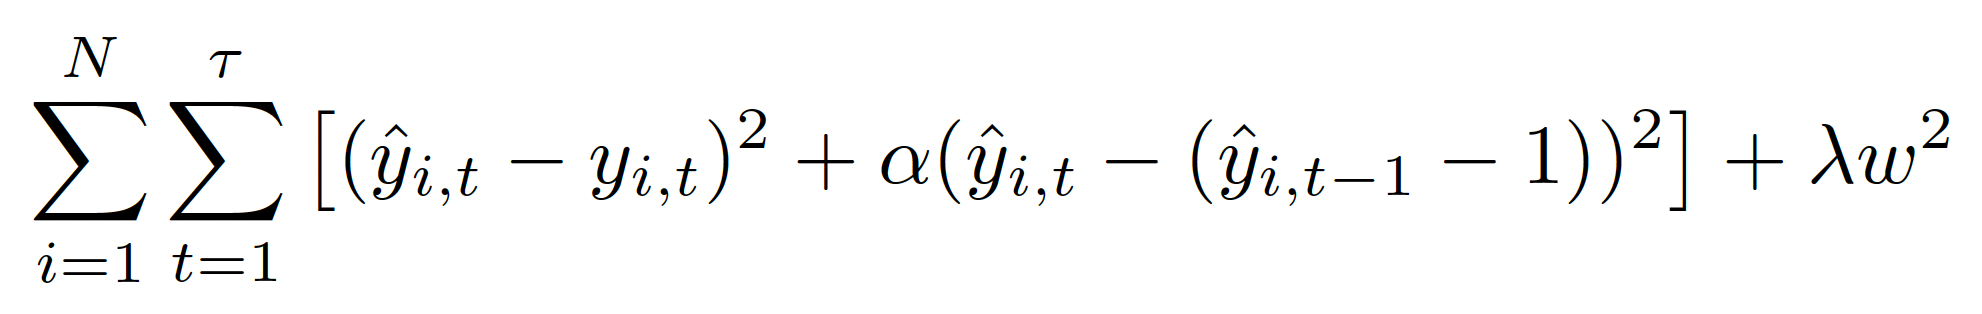

In [25]:
# Multi var linear regression

class Linear_Regression_TD() :
  def __init__( self, alpha=0, lambda_ridge=0 ) :
    self.alpha = alpha
    self.lambda_ridge = lambda_ridge  # Ridge regression

  def fit(self, X, Y, alpha, lambd) :
    self.l, self.p = X.shape
    self.alpha = alpha
    self.lambda_ridge = lambd
    # weight initializer
    self.p = (self.p + 1)         # add constant term.

    self.add_X = np.ones(self.l)
    self.X = np.c_[self.add_X, X]

    self.array_Y = np.array(Y[0:].to_numpy())
    self.array_Y.reshape( self.l, 1 )
    self.Y = self.array_Y
    self.W = np.zeros( self.p ) # W : 0 (b is included)

    self.identity = np.identity( n = self.p ) # Ridge regression
    self.lambda_identity = self.lambda_ridge * self.identity   # lambda * I

    # 각각의 행렬 연산
    X_T_X = (self.X.T) @ (self.X)          # X^(T)X
    X_diff_T_X_diff_sum = np.zeros( [self.p, self.p] )

    for i in range(1, self.l):
      X_diff_T_X_diff = (( self.X[i, :] - self.X[i - 1, :] ).reshape(self.p, 1)) @ (( self.X[i, :] - self.X[i - 1, :] ).reshape(1, self.p))
      X_diff_T_X_diff_sum += X_diff_T_X_diff


    X_T_Y = (self.X.T) @ (self.Y)
    X_T_Y = X_T_Y.reshape( self.p, 1 )
    X_diff_T_sum = np.zeros( [self.p, 1] )

    for i in range(1, self.l):
      X_diff_T = (( self.X[i, :] - self.X[i - 1, :] ).reshape( self.p, 1 ))
      X_diff_T_sum += X_diff_T

    self.W = np.linalg.inv(X_T_X + (self.alpha * X_diff_T_X_diff_sum) + self.lambda_identity) @ (X_T_Y - self.alpha * X_diff_T_sum)

    print(self.W)
    print(self.W.shape)

# X를 입력 받으면 첫 열에 1의 값을 갖는 열을 추가해서 계산해야함. (입력으로 들어오는 X는 (n, 21)이니 (n, 22)로 바꿔줘야 함)
  def predict( self, X) :
    l_X, p_X = X.shape
    p_X = p_X + 1
    add_col = np.ones(l_X)

    X = np.c_[add_col, X]

    return X.dot( self.W )

TD Style Loss function + Crucial moments (ridge regression)**

In [26]:
# loss 3

filtered_data_2 = X_train_1_s[y_train_clip <= 20]
filtered_labels_2 = y_train_clip[y_train_clip <= 20]

lr3 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr3.fit(filtered_data_2, filtered_labels_2, 0.5, 10) #Fitting

y_lr_train_3 = lr3.predict(X_train_1_s)
evaluate(y_train_clip, y_lr_train_3, label='train')

y_lr_valid_3 = lr3.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_3, label='valid')

y_lr_full_3 = lr3.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_3, label='full data')


[[ 9.55672424]
 [ 0.        ]
 [-2.16645178]
 [-2.25306623]
 [-3.71397659]
 [ 0.        ]
 [ 9.55672424]
 [ 6.78376827]
 [-3.6454211 ]
 [-4.1400784 ]
 [ 0.        ]
 [-4.44878675]
 [ 7.87660206]
 [-3.05283914]
 [-2.43362868]
 [-2.71577369]
 [ 0.        ]
 [-1.62542589]
 [ 0.        ]
 [ 0.        ]
 [ 5.88406406]
 [ 5.22912493]]
(22, 1)
train set RMSE:96.50640510497674, R2:-1.610809774977903
valid set RMSE:114.87201705358963, R2:-1.469853497088172
full data set RMSE:106.89983525153974, R2:-1.4086647657746778


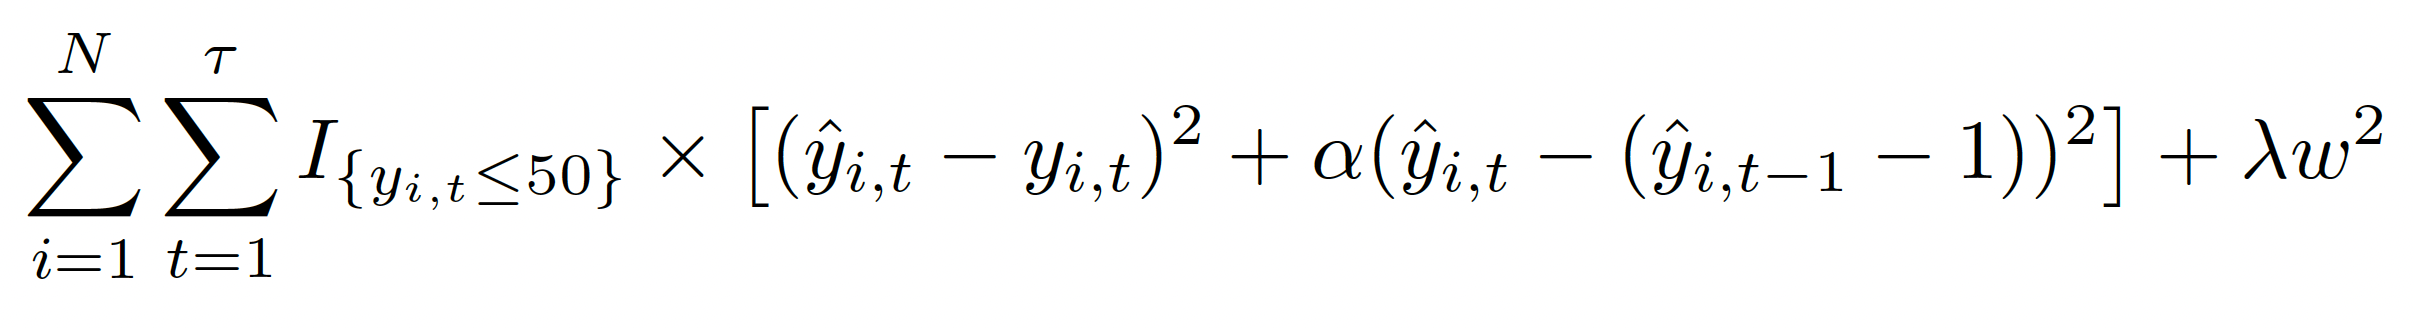

In [28]:
# 4. loss 4

filtered_data_2 = X_train_1_s[y_train_clip <= 50]
filtered_labels_2 = y_train_clip[y_train_clip <= 50]

lr4 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr4.fit(filtered_data_2, filtered_labels_2, 0.5, 10) #Fitting

y_lr_train_4 = lr4.predict(X_train_1_s)
evaluate(y_train_clip, y_lr_train_4, label='train')

y_lr_valid_4 = lr4.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_4, label='valid')

y_lr_full_4 = lr4.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_4, label='full data')

[[ 25.56152389]
 [  0.        ]
 [ -4.34825633]
 [ -4.72060647]
 [ -8.1656294 ]
 [  0.        ]
 [ 18.3183243 ]
 [ 14.22560939]
 [ -9.97438141]
 [-13.03837167]
 [  0.        ]
 [-12.82137403]
 [ 16.3849925 ]
 [ -7.89595041]
 [ -8.53524197]
 [ -7.43586434]
 [  0.        ]
 [ -3.66592215]
 [  0.        ]
 [  0.        ]
 [  9.48317602]
 [  9.99848415]]
(22, 1)
train set RMSE:76.17980251176621, R2:-0.6268317448984864
valid set RMSE:96.26206909383734, R2:-0.7344152519959246
full data set RMSE:87.2795032363973, R2:-0.6056349742023353


Merge!

In [29]:
# loss function 별 dataframe들을 list로 저장
y_lr_valid_dfs = [pd.DataFrame(y_lr_valid_1, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_2, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_3, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_4, columns=['predicted RUL'])]
merged_valid_dfs = []

# 각 dataframe에 병합하고 출력
for i, y_lr_valid_df in enumerate(y_lr_valid_dfs, start=1):
    merged_valid = pd.concat([X_valid_index_names, y_lr_valid_df, y_valid], axis=1)
    merged_valid_dfs.append(merged_valid)
    print(f"Merged Valid DataFrame {i}:\n", merged_valid)

Merged Valid DataFrame 1:
       unit_number  time_cycles  predicted RUL  RUL
0              71            1      34.176258  207
1              71            2      31.652141  206
2              71            3      34.287991  205
3              71            4      33.263280  204
4              71            5      36.399147  203
...           ...          ...            ...  ...
6496          100          196       2.222213    4
6497          100          197       0.613001    3
6498          100          198      -1.240804    2
6499          100          199      -3.647069    1
6500          100          200      -2.592746    0

[6501 rows x 4 columns]
Merged Valid DataFrame 2:
       unit_number  time_cycles  predicted RUL  RUL
0              71            1      50.632505  207
1              71            2      47.159429  206
2              71            3      51.407043  205
3              71            4      50.082682  204
4              71            5      54.343519  203
...

In [30]:
# loss function 별 dataframe들을 list로 저장
y_lr_full_dfs = [pd.DataFrame(y_lr_full_1, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_2, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_3, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_4, columns=['predicted RUL'])]
merged_full_dfs = []

# 각 dataframe에 병합하고 출력
for i, y_lr_full_df in enumerate(y_lr_full_dfs, start=1):
    merged_full = pd.concat([X_full_index_names, y_lr_full_df, y_full], axis=1)
    merged_full_dfs.append(merged_full)
    print(f"Merged full DataFrame {i}:\n", merged_full)

Merged full DataFrame 1:
        unit_number  time_cycles  predicted RUL  RUL
0                1            1      42.411084  191
1                1            2      40.623695  190
2                1            3      42.241578  189
3                1            4      45.089741  188
4                1            5      40.772821  187
...            ...          ...            ...  ...
20626          100          196       7.783122    4
20627          100          197       6.444383    3
20628          100          198       4.786985    2
20629          100          199       2.588785    1
20630          100          200       3.701367    0

[20631 rows x 4 columns]
Merged full DataFrame 2:
        unit_number  time_cycles  predicted RUL  RUL
0                1            1      63.780923  191
1                1            2      62.025099  190
2                1            3      64.781917  189
3                1            4      69.143419  188
4                1            5      6

# Visualization

**(1) 각 엔진의 online predict value (test data 71~100)**

(X-axis : Time cycles, Y-axis : predicted RUL)

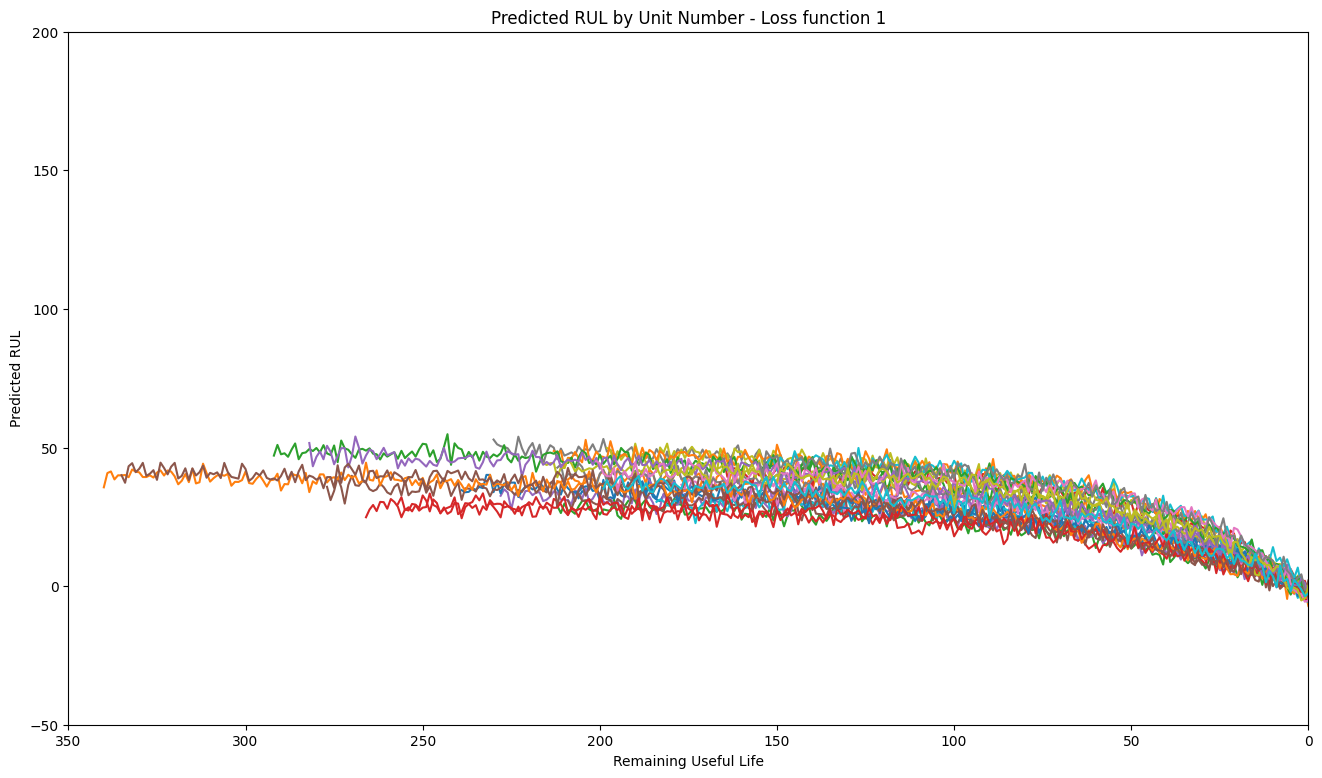

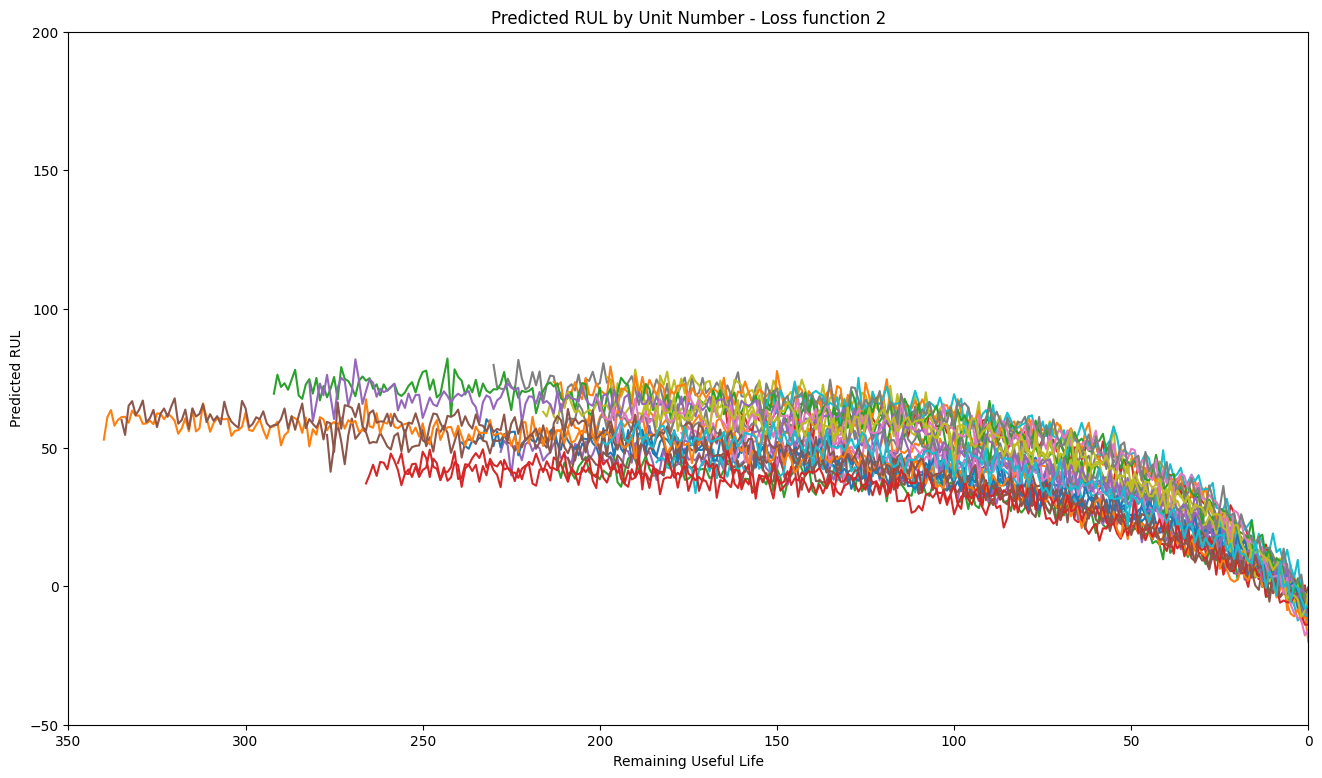

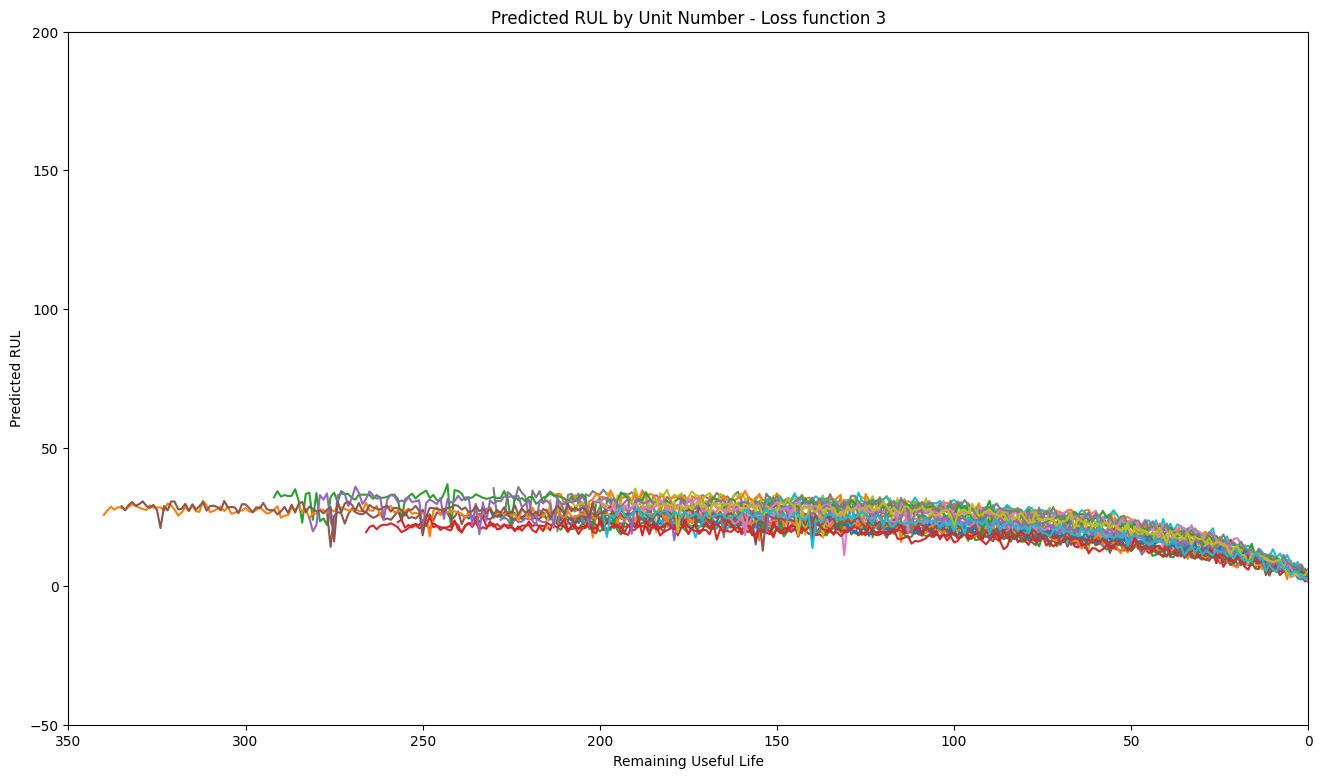

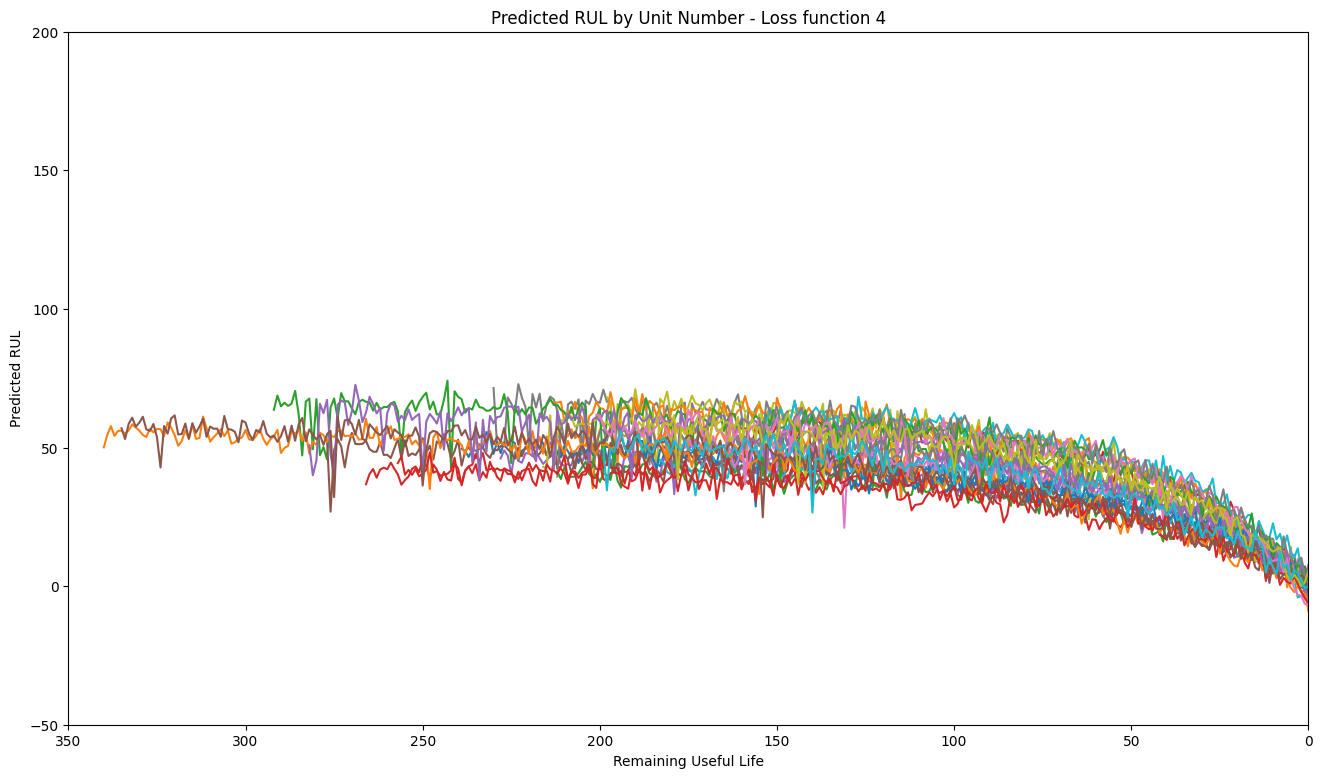

In [31]:
# merged_valid_dfs 리스트에 있는 데이터프레임들에 대해 반복 수행
for i, merged_valid_df in enumerate(merged_valid_dfs, start=1):
    # 데이터프레임에서 unit_number을 기준으로 그룹화
    grouped = merged_valid_df.groupby('unit_number')

    # 그래프를 그릴 subplot을 설정
    fig, ax = plt.subplots(figsize=(16, 9))

    # unit_number 별로 그래프 그리기
    for unit, group in grouped:
        ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

    ax.set_xlabel('Remaining Useful Life')
    ax.set_ylabel('Predicted RUL')
    ax.set_title(f'Predicted RUL by Unit Number - Loss function {i}')
    #ax.legend(loc='upper right')  # 범례 추가

    # 그래프 출력 설정
    plt.xlim(350, 0)  # reverse the x-axis so RUL counts down to zero
    plt.ylim(-50, 200)
    plt.show()

**Threshold, Actual Operation Time**

**Add "Cumulative Operation Time", "Total Cost" Columns**


Cost : Failure (10,000), replace (1000)

In [32]:
# define list of threshold_value
threshold_start = -40        # -40
threshold_end = 90           # 90
threshold_values = list(range(threshold_start, threshold_end + 1))

# 각 threshold_value에 대한 dataframe을 담을 리스트를 생성.
by_threshold_dfs_list = []

# Define cost (Tentative Value)
REPLACE_COST = 1000       # replace cost를 크게 늘려도, 반등하는 최저점을 찾을 수 없음 <- Total cost로 해서 상수가 나왔었음. 시간당 cost로 환산하면 커브 그려짐.
FAILURE_COST = 10000

# merged_valid_dfs 리스트 내에 있는 각 데이터프레임에 대해 반복 수행

for merged_valid_df in merged_valid_dfs:
    by_threshold_dfs = []

    # threshold_value 별 처리.
    for threshold_value in threshold_values:

        cumulative_operation_time = 0
        total_cost = 0
        average_cost = 0             # total cost / operation time
        by_threshold_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])

        grouped = merged_valid_df.groupby('unit_number')

        for unit, group in grouped:
            operation_time = None

            max_RUL = group['RUL'].max()

            for index, row in group.iterrows():
                if row['predicted RUL'] <= threshold_value:   # 'predicted RUL'이 threshold보다 작거나 같으면 replace! (이후 for문 탈출)
                    operation_time = row['time_cycles']
                    cumulative_operation_time += operation_time
                    total_cost += REPLACE_COST
                    break


            if pd.isna(operation_time):
                cumulative_operation_time += max_RUL
                total_cost += FAILURE_COST

            average_cost = total_cost / cumulative_operation_time  # calculate average cost
            by_threshold_df = by_threshold_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                      'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                      'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

        by_threshold_dfs.append(by_threshold_df)

    by_threshold_dfs_list.append(by_threshold_dfs)

**Apply full data set**

In [33]:
# 각 threshold_value에 대한 dataframe을 담을 리스트를 생성.
full_by_threshold_dfs_list = []

# merged_full_dfs 리스트 내에 있는 각 데이터프레임에 대해 반복 수행
for merged_full_df in merged_full_dfs:
    full_by_threshold_dfs = []

    # threshold_value 별 처리.
    for threshold_value in threshold_values:

        cumulative_operation_time = 0
        total_cost = 0
        average_cost = 0             # total cost / operation time
        full_by_threshold_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])

        grouped = merged_full_df.groupby('unit_number')

        for unit, group in grouped:
            operation_time = None

            max_RUL = group['RUL'].max()

            for index, row in group.iterrows():
                if row['predicted RUL'] <= threshold_value:
                    operation_time = row['time_cycles']
                    cumulative_operation_time += operation_time
                    total_cost += REPLACE_COST
                    break

            if pd.isna(operation_time):
                cumulative_operation_time += max_RUL
                total_cost += FAILURE_COST

            average_cost = total_cost / cumulative_operation_time  # calculate average cost
            full_by_threshold_df = full_by_threshold_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                      'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                      'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

        full_by_threshold_dfs.append(full_by_threshold_df)

    full_by_threshold_dfs_list.append(full_by_threshold_dfs)
#print(full_by_threshold_dfs_list[1][1])

In [34]:
print(full_by_threshold_dfs_list[1][1])
print(full_by_threshold_dfs_list[2][1])

    unit_number actual operation time  actual RUL  Cumulative Operation Time  \
0           1.0                   NaN       191.0                      191.0   
1           2.0                   NaN       286.0                      477.0   
2           3.0                   NaN       178.0                      655.0   
3           4.0                   NaN       188.0                      843.0   
4           5.0                   NaN       268.0                     1111.0   
..          ...                   ...         ...                        ...   
95         96.0                   NaN       335.0                    19792.0   
96         97.0                   NaN       201.0                    19993.0   
97         98.0                   NaN       155.0                    20148.0   
98         99.0                   NaN       184.0                    20332.0   
99        100.0                   NaN       199.0                    20531.0   

    Total Cost  Average Cost  
0      1

**(2) Threshold를 x축으로 두고 분석**

(x-axis : Threshold, y-axis : Number of replace failures)


(x-axis : Threshold, y-axis : Total Cost)

In [35]:
# Total time을 고정하는 것이 아닌, 사용한 엔진 수를 고정해 비교. (23.09.09)

# empty list를 생성, threshold와 count of NaN을 저장할 list 초기화.
# 정해진 operation time까지의 Total Cost를 저장할 list 초기화.
nan_counts_list = []
average_cost_list_list = []
average_usage_time_list_list = []

# 각 by_threshold_dfs 리스트 내의 by_threshold_df에 대해 반복 수행
for by_threshold_dfs in by_threshold_dfs_list:
    nan_counts = []
    average_cost_list = []
    average_usage_time_list = []

    # 각 dataframe마다 수행.
    for df in by_threshold_dfs:

        average_usage_time = df['Cumulative Operation Time'].iloc[-1] / (len(df.index) + 1)  # 전체 엔진에 대한 평균 사용 시간 저장.
        average_usage_time_list.append(average_usage_time)                                   # 결과를 리스트에 다시 저장.


        average_cost_by_threshold = df['Average Cost'].iloc[-1]                                  # 'Average Cost'의 열에서 마지막 값을 가져옴.
        average_cost_list.append(average_cost_by_threshold)                                      # 'Average Cost'를 list에 저장

        # 'actual operation time' column의 NaN 개수 count 후 리스트에 추가. index의 끝까지 Nan을 count.
        nan_count = df.loc[:, 'actual operation time'].isna().sum()
        nan_counts.append(nan_count)

    nan_counts_list.append(nan_counts)
    average_cost_list_list.append(average_cost_list)
    average_usage_time_list_list.append(average_usage_time_list)

# 각 by_threshold_dfs 리스트 내에 대한 결과를 저장하는 데이터프레임 생성
nan_counts_and_cost_df_list = []
for i, by_threshold_dfs in enumerate(by_threshold_dfs_list, start=1):
    threshold_values = list(range(threshold_start, threshold_end + 1))
    nan_counts_and_cost_df = pd.DataFrame({'Threshold': threshold_values, 'Number of replace failures': nan_counts_list[i - 1],
                                           'Average Cost': average_cost_list_list[i - 1], 'Average usage time' : average_usage_time_list_list[i - 1]})
    nan_counts_and_cost_df_list.append(nan_counts_and_cost_df)
    print(f"DataFrame for merged_valid_df {i}:\n", nan_counts_and_cost_df)

DataFrame for merged_valid_df 1:
      Threshold  Number of replace failures  Average Cost  Average usage time
0          -40                          30     46.360686          208.741935
1          -39                          30     46.360686          208.741935
2          -38                          30     46.360686          208.741935
3          -37                          30     46.360686          208.741935
4          -36                          30     46.360686          208.741935
..         ...                         ...           ...                 ...
126         86                           0   1000.000000            0.967742
127         87                           0   1000.000000            0.967742
128         88                           0   1000.000000            0.967742
129         89                           0   1000.000000            0.967742
130         90                           0   1000.000000            0.967742

[131 rows x 4 columns]
DataFrame for merg

**apply full data**

In [36]:
# Total time을 고정하는 것이 아닌, 사용한 엔진 수를 고정해 비교. (23.09.09)

# empty list를 생성, threshold와 count of NaN을 저장할 list 초기화.
# 정해진 operation time까지의 Total Cost를 저장할 list 초기화.
full_nan_counts_list = []
full_average_cost_list_list = []
full_average_usage_time_list_list = []

# 각 by_threshold_dfs 리스트 내의 by_threshold_df에 대해 반복 수행
for full_by_threshold_dfs in full_by_threshold_dfs_list:
    full_nan_counts = []
    full_average_cost_list = []
    full_average_usage_time_list = []

    # 각 dataframe마다 수행.
    for df in full_by_threshold_dfs:

        full_average_usage_time = df['Cumulative Operation Time'].iloc[-1] / (len(df.index) + 1)  # 전체 엔진에 대한 평균 사용 시간 저장.
        full_average_usage_time_list.append(full_average_usage_time)                                   # 결과를 리스트에 다시 저장.


        full_average_cost_by_threshold = df['Average Cost'].iloc[-1]                            # 'Average Cost'의 열에서 마지막 값을 가져옴.
        full_average_cost_list.append(full_average_cost_by_threshold)                           # 'Aberage cost'를 list에 저장

        # 'actual operation time' column의 NaN 개수 count 후 리스트에 추가. index의 끝까지 Nan을 count.
        full_nan_count = df.loc[:, 'actual operation time'].isna().sum()
        full_nan_counts.append(full_nan_count)

    full_nan_counts_list.append(full_nan_counts)
    full_average_cost_list_list.append(full_average_cost_list)
    full_average_usage_time_list_list.append(full_average_usage_time_list)

# 각 by_threshold_dfs 리스트 내에 대한 결과를 저장하는 데이터프레임 생성
full_nan_counts_and_cost_df_list = []
for i, full_by_threshold_dfs in enumerate(full_by_threshold_dfs_list, start=1):
    threshold_values = list(range(threshold_start, threshold_end + 1))
    full_nan_counts_and_cost_df = pd.DataFrame({'Threshold': threshold_values, 'Number of replace failures': full_nan_counts_list[i - 1],
                                           'Total Cost': full_average_cost_list_list[i - 1], 'Average usage time' : full_average_usage_time_list_list[i - 1]})
    full_nan_counts_and_cost_df_list.append(full_nan_counts_and_cost_df)
    print(f"DataFrame for merged_valid_df {i}:\n", full_nan_counts_and_cost_df)

DataFrame for merged_valid_df 1:
      Threshold  Number of replace failures   Total Cost  Average usage time
0          -40                         100    48.706834          203.277228
1          -39                         100    48.706834          203.277228
2          -38                         100    48.706834          203.277228
3          -37                         100    48.706834          203.277228
4          -36                         100    48.706834          203.277228
..         ...                         ...          ...                 ...
126         86                           0  1000.000000            0.990099
127         87                           0  1000.000000            0.990099
128         88                           0  1000.000000            0.990099
129         89                           0  1000.000000            0.990099
130         90                           0  1000.000000            0.990099

[131 rows x 4 columns]
DataFrame for merged_valid_df 

**Scatter plot - Threshold에 따른 replace 실패 횟수와, 엔진 평균 사용시간 - Full data**

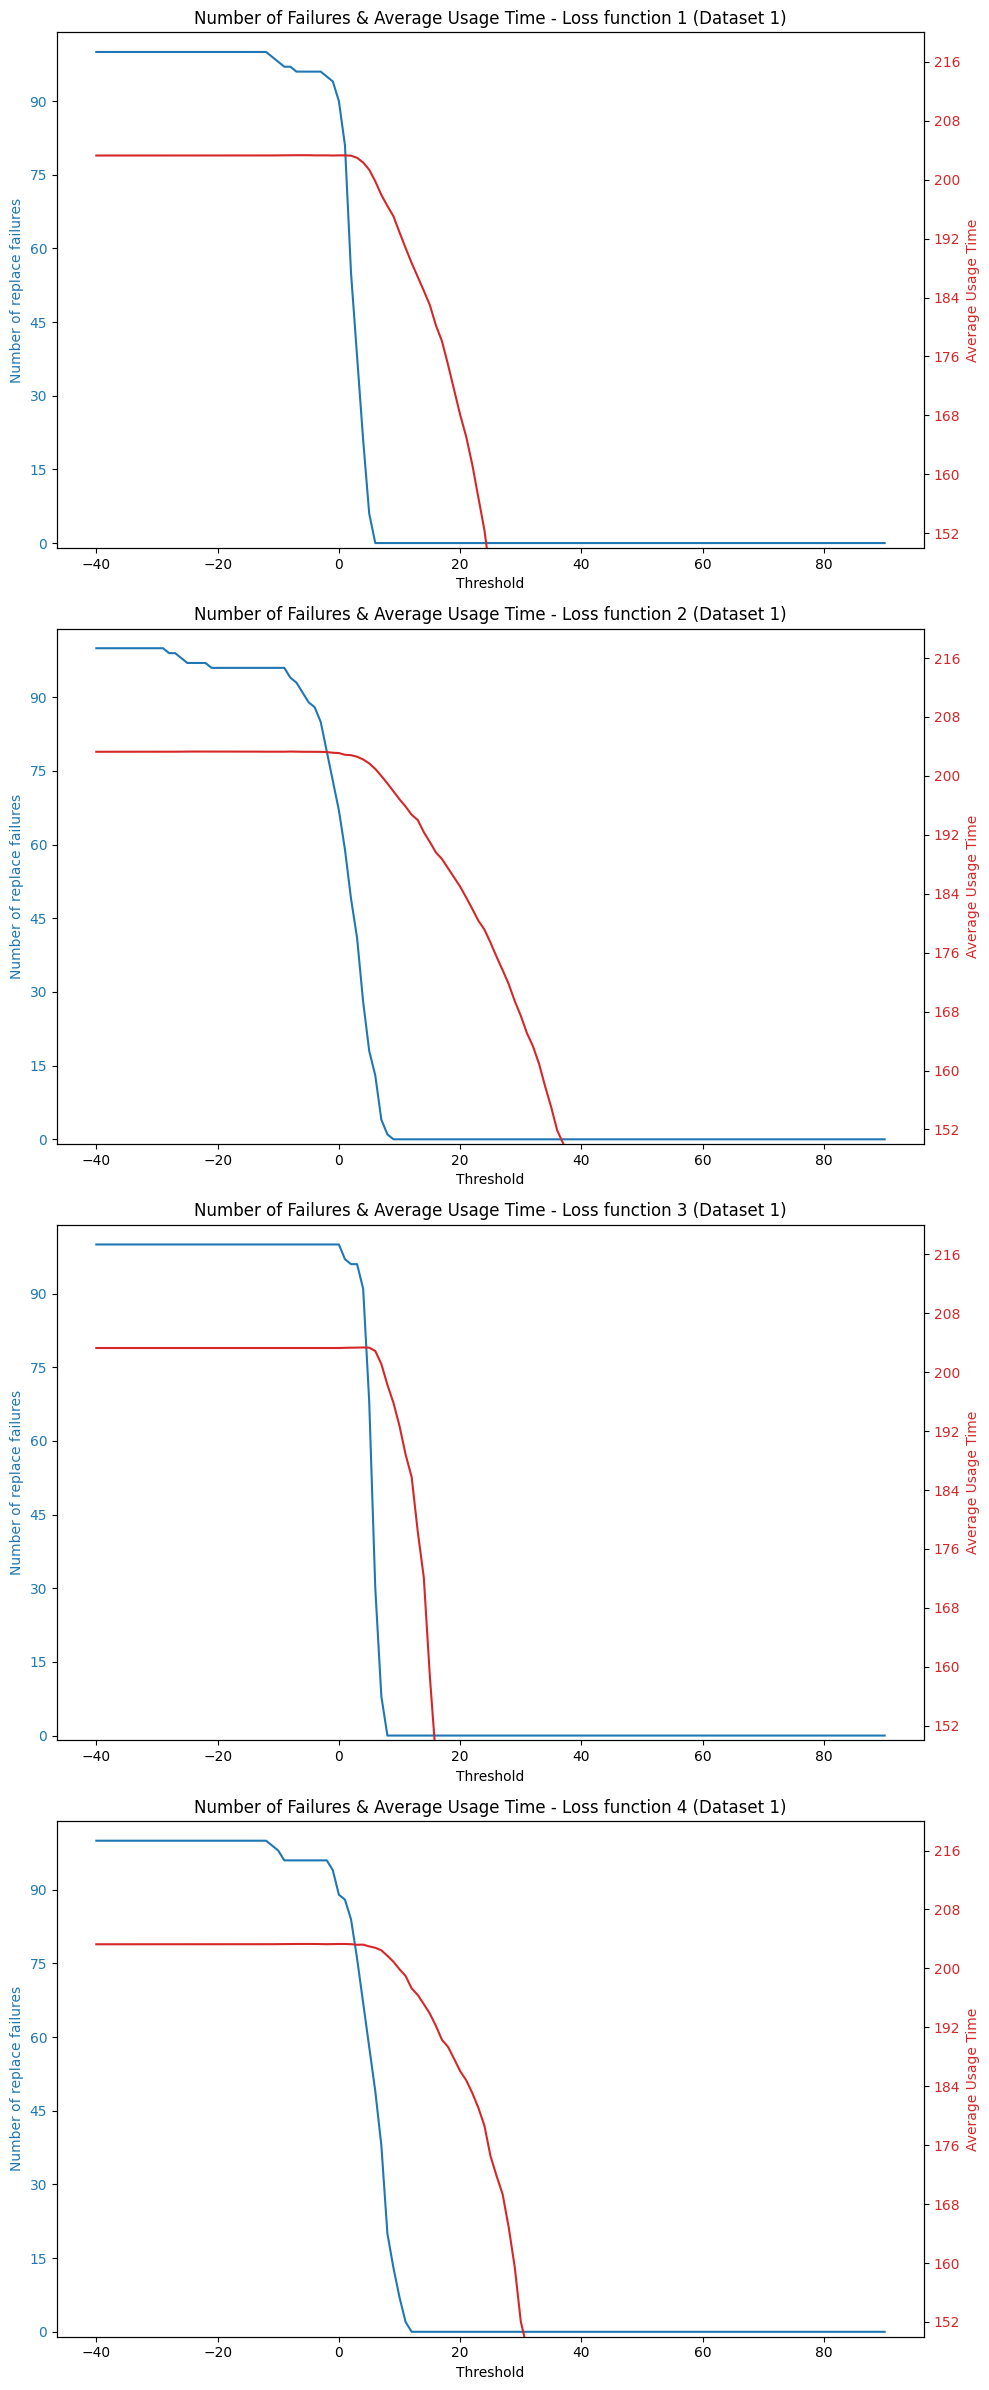

In [37]:
fig, axs = plt.subplots(len(full_nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(full_nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Number of replace failures', color=color)
    ax1.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Number of replace failures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-1,104) ### for Dataset1

    # 오른쪽 Y축 그래프 (Average Usage Time)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Usage Time', color=color)
    ax2.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Average usage time'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(150,220) ### for Dataset1


    # 그래프 제목 설정
    ax1.set_title(f'Number of Failures & Average Usage Time - Loss function {i} (Dataset 1)')


# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

Average Cost

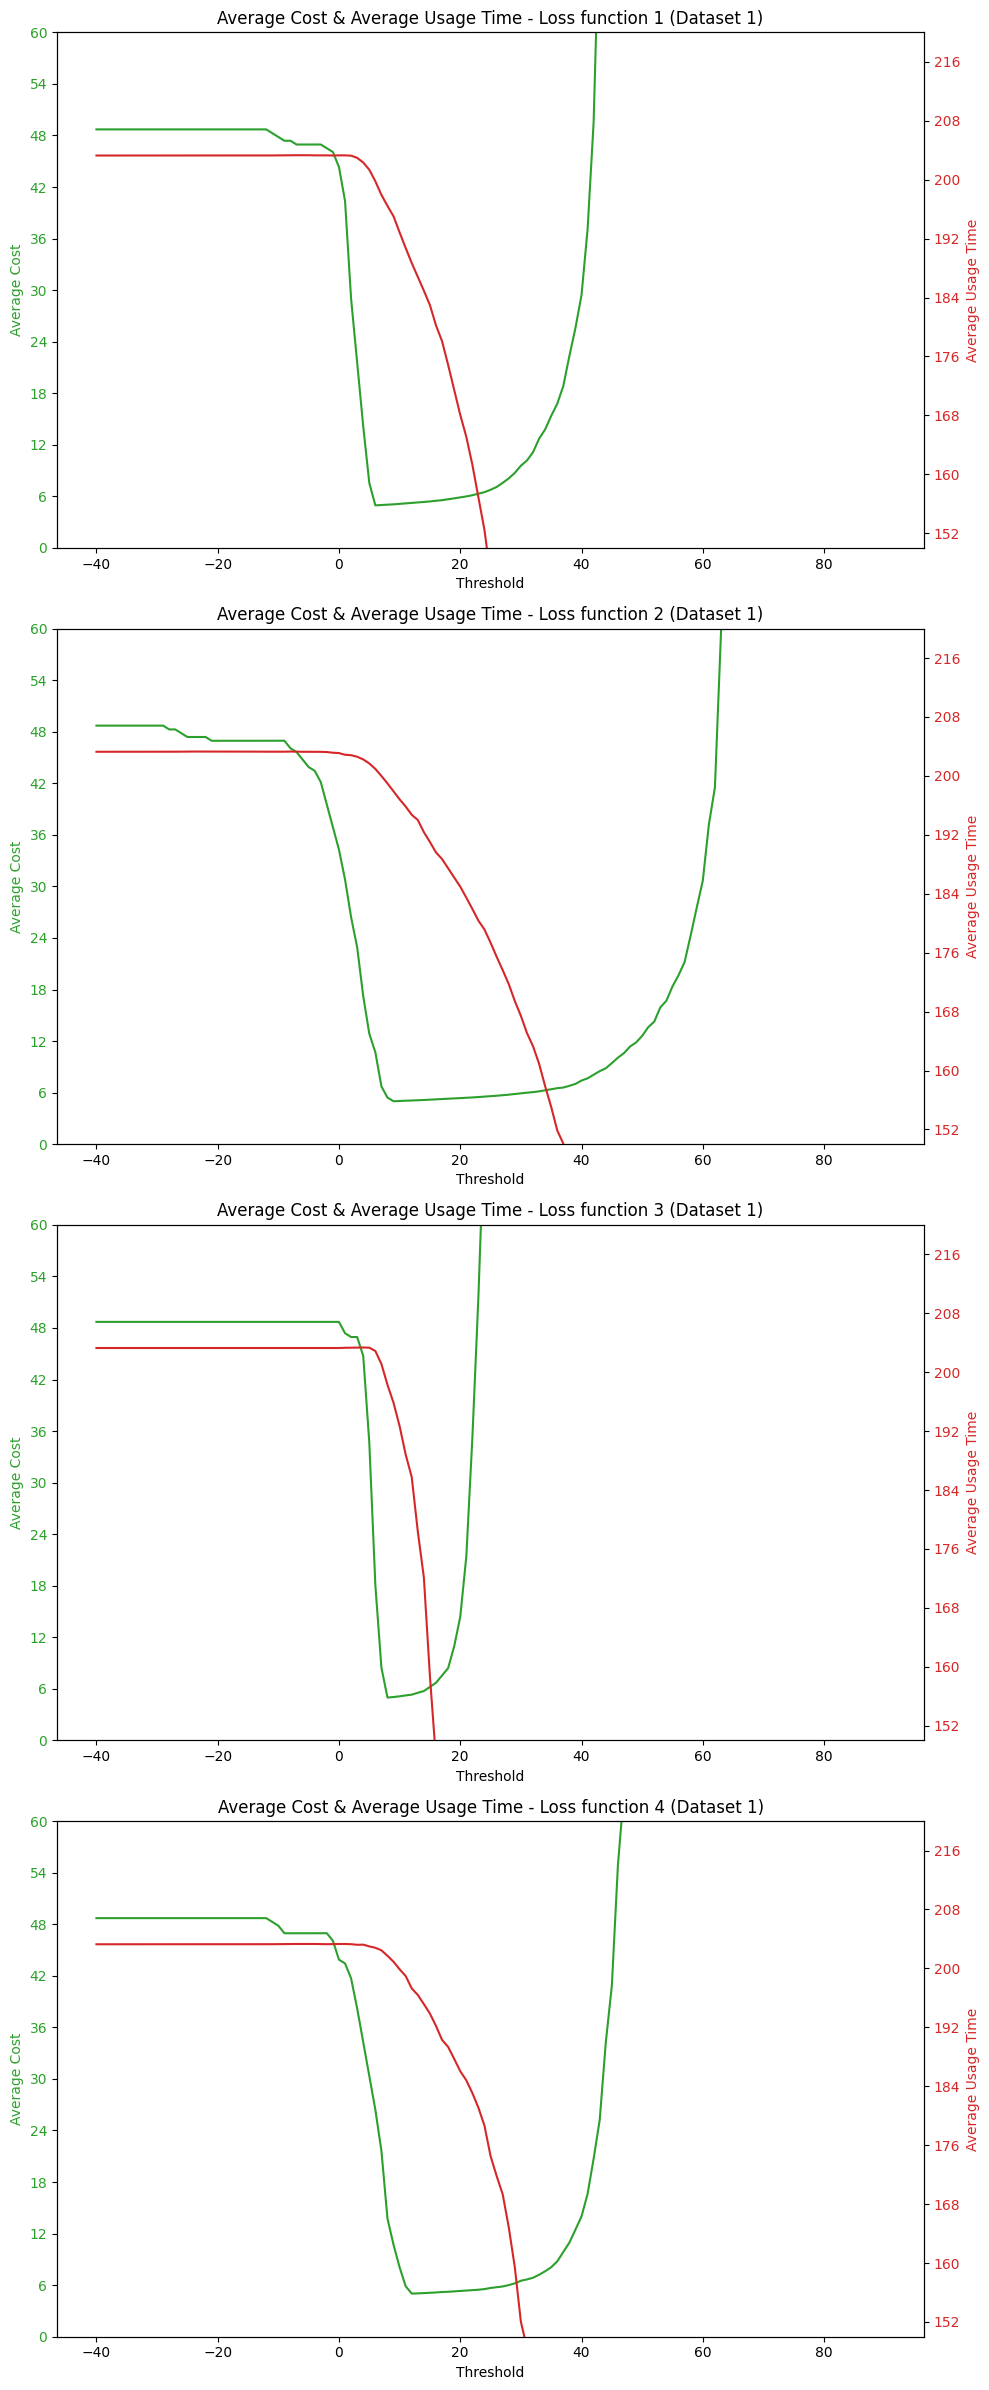

In [38]:
fig, axs = plt.subplots(len(full_nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(full_nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Average Cost)
    color = 'tab:green'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Average Cost', color=color)
    ax1.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Total Cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(0,60) ### for dataset1

    # 오른쪽 Y축 그래프 (Average Usage Time)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Usage Time', color=color)
    ax2.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Average usage time'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(150,220) ### for Dataset1


    # 그래프 제목 설정
    ax1.set_title(f'Average Cost & Average Usage Time - Loss function {i} (Dataset 1)')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

**Scatter Plot - (Number of Failures vs. Average usage time)**

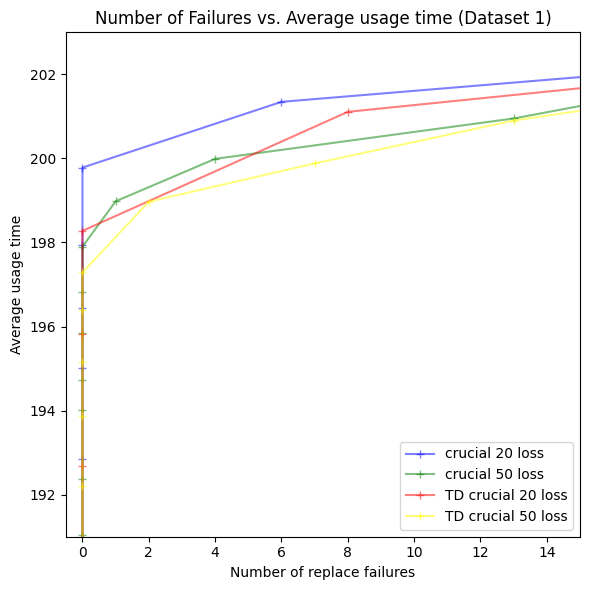

In [53]:
# Create a list of labels
custom_labels = ['crucial 20 loss', 'crucial 50 loss', 'TD crucial 20 loss', 'TD crucial 50 loss']

# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=custom_labels[i],  # Use the custom label from the list
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim(191, 203)  # for dataset1
ax.set_xlim(-0.5, 15)

# Show the plot
plt.tight_layout()
plt.show()
